# A testing ground for pyPIPS functionality

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
from pyCRMtools.pycaps import arps_read
from pyCRMtools.pycaps import pycaps_fields
from pyCRMtools.pycaps import calvars_radar as radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
# Read in the SATP DataArrays
PIPS_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/full_PIPS_dataset/'
# ND_combined_filename = 'ND_combined_full_dataset_60s.nc'
# ND_combined_path = os.path.join(PIPS_dir, ND_combined_filename)
# ND_avg_filename = 'ND_avg_full_dataset_60s.nc'
# ND_avg_path = os.path.join(PIPS_dir, ND_avg_filename)

# ND_combined = xr.open_dataarray(ND_combined_path)
# ND_avg = xr.open_dataarray(ND_avg_path)
# ND_avg = xr.load_dataset(ND_avg_path)
parsivel_combined_filename = 'parsivel_combined_IOP_4A_4D_D1_2016_PIPS1A_60s.nc'
parsivel_combined_path = os.path.join(PIPS_dir, parsivel_combined_filename)
parsivel_combined_ds = xr.open_dataset(parsivel_combined_path)

In [3]:
print(parsivel_combined_ds)


<xarray.Dataset>
Dimensions:            (diameter_bin: 32, fallspeed_bin: 32, parameter: 3, time: 5325)
Coordinates:
  * time               (time) datetime64[ns] 2016-04-27T22:51:13 ... 2016-05-01T15:35:13
    fallspeed          (fallspeed_bin) float64 ...
    diameter           (diameter_bin) float64 ...
    min_diameter       (diameter_bin) float64 ...
    max_diameter       (diameter_bin) float64 ...
    min_fallspeeds     (fallspeed_bin) float64 ...
    max_fallspeeds     (fallspeed_bin) float64 ...
  * parameter          (parameter) object 'N0' 'lamda' 'alpha'
Dimensions without coordinates: diameter_bin, fallspeed_bin
Data variables:
    precipintensity    (time) float64 ...
    precipaccum        (time) float64 ...
    parsivel_dBZ       (time) float64 ...
    pcount             (time) int64 ...
    signal_amplitude   (time) float64 ...
    pvoltage           (time) float64 ...
    sensor_temp        (time) float64 ...
    sample_interval    (time) timedelta64[ns] ...
    windsp

In [45]:
def mu_lamda(lamda, coeff1, coeff2, coeff3):
    mu = coeff1*lamda**2. + coeff2*lamda + coeff3
    return mu

coeff1 = -0.0184
coeff2 = 0.9685
coeff3 = -1.9453

pcount = parsivel_combined_ds['pcount']
Dm43 = parsivel_combined_ds['Dm43'] * 1000.
sigma = parsivel_combined_ds['sigma'] * 1000.
DSD_TMM246 = parsivel_combined_ds['DSD_TMM246']
DSD_TMM246 = DSD_TMM246.where(DSD_TMM246.sel(parameter='lamda') < 20000.)
DSD_TMM246 = DSD_TMM246.where(DSD_TMM246.sel(parameter='alpha') < 30.)

lamda = DSD_TMM246.sel(parameter='lamda') / 1000.
mu = mu_lamda(lamda, coeff1, coeff2, coeff3)

sigma_retr = np.sqrt((mu + 4)/lamda**2.)
Dm43_retr = (4 + mu)/lamda

    

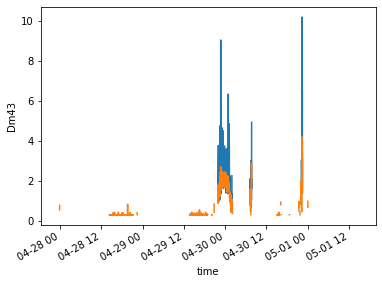

In [51]:
Dm43_retr.plot()
Dm43.plot()

(0.0, 2.5)

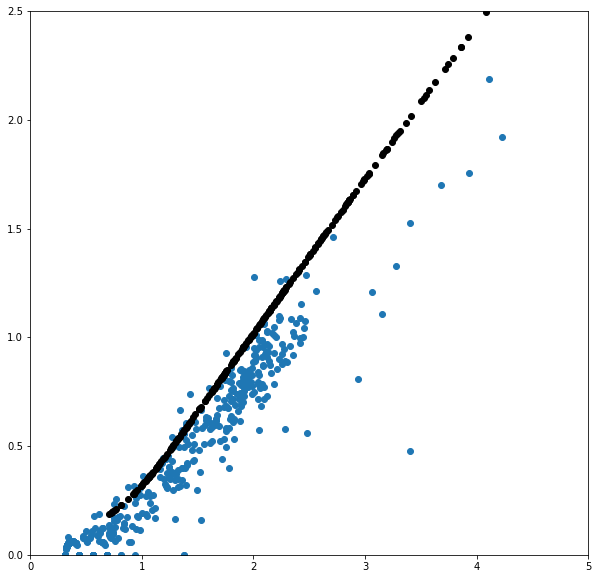

In [52]:
fig, ax = plt.subplots(figsize=(10, 10))
Dm43_plt = Dm43.where(pcount > 0, drop=True)
sigma_plt = sigma.where(pcount > 0, drop=True)
sigma_retr_plt = sigma_retr.where(pcount > 0, drop=True)
Dm43_retr_plt = Dm43_retr.where(pcount > 0, drop=True)
ax.scatter(Dm43_plt, sigma_plt)
ax.scatter(Dm43_retr_plt, sigma_retr_plt, color='k')

ax.set_xlim(0.0, 5.0)
ax.set_ylim(0.0, 2.5)

In [ ]:
ND_combined = pipsio.reconstruct_MultiIndex(ND_combined, ['D0_idx', 'RR_idx'], 'D0_RR')
print(ND_combined)
ND_combined.close()

In [ ]:
ND_groups = ND_combined.groupby('D0_RR')
# Now average in each RR-D0 bin
ND_avg = ND_groups.mean(dim='D0_RR')
ND_avg.name = 'SATP_ND_full_dataset'
ND_avg.attrs = ND_combined.attrs
ND_avg = ND_avg.reset_index('D0_RR')
ND_avg_ncfile_name = 'ND_avg_full_dataset_60s.nc'
ND_avg_ncfile_path = os.path.join(PIPS_dir, ND_avg_ncfile_name)
print("Dumping {}".format(ND_avg_ncfile_path))
ND_avg.to_netcdf(ND_avg_ncfile_path)

In [ ]:
D0_bins = ND_avg['D0']
RR_bins = ND_avg['RR']

print(RR_bins)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(ND_combined['D0'])
fig2, ax2 = plt.subplots(figsize=(10,10))
ax2.hist(ND_combined['RR'])

In [ ]:
ND_groups = ND_combined.groupby('D0_RR')

In [ ]:
for group, ND_group in list(ND_groups)[:-1]:
    num_DSDs = ND_group.sizes['D0_RR']
    print(group, num_DSDs)

In [ ]:
print(D0_bins[0])
print(RR_bins[0])
for group, ND_group in list(ND_groups)[:-1]:
    num_DSDs = ND_group.sizes['D0_RR']
    # print(group, num_DSDs)
    if num_DSDs > 10 and group[1] > 0:
        fig, ax = plt.subplots(figsize=(10,10))
        ND_group_avg = ND_group.mean('D0_RR')
        print(D0_bins[group[0]], RR_bins[group[1]])
        for ND in ND_group:
            # print(ND)
            ax.plot(ND_group['diameter'], ND, color='0.7', alpha=0.5)
            ax.plot(ND_group['diameter'], ND_group_avg, 'k')
#             ax.plot(avg_diameter,
#                     Nc_bin_avg[r,
#                                d],
#                     'k',
#                     label='(R,D0) = (%2.2f' % midpoint_R + ',%2.2f' % midpoint_D0 + ')')
            ax.set_yscale('log')
            ax.set_ylim(10.**-1.0, 10.**5.0)
            ax.set_ylabel('Number Concentration, # m^-3 mm^-1')
            ax.set_xlim(0.0, 8.0)
            ax.set_xlabel('Diameter, mm')
            ax.tick_params(direction='in', length=6, top='on', right='on')
#             ax.legend(
#                 bbox_to_anchor=(
#                     1.,
#                     1.),
#                 loc='upper right',
#                 ncol=1,
#                 fancybox=True,
#                 shadow=False)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

hist, xedges, yedges = np.histogram2d(ND_combined['RR'], ND_combined['D0'], bins=(RR_bins, D0_bins))
hist = np.ma.masked_where(hist <= 0.0, hist)
# add 2D color grid of bin sum
ax.set_xscale('log')
C = ax.pcolormesh(RR_bins, D0_bins, hist.T, vmin=0.0, vmax=20.0)
ax.set_xlabel('Rainrate')
ax.set_ylabel('D0')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(C, orientation='vertical', cax=cax)

In [ ]:
PIPS_IO_dict = {
    'dataset_name': 'full_dataset',
    'deployment_name': 'full_dataset',
    'PIPS_dir': '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/full_PIPS_dataset_links',
    'plot_dir': '/Users/dawson29/sshfs_mounts/depot/data/Projects/VORTEXSE/obsdata/full_PIPS_dataset_links',
    'requested_interval': 60.
}

PIPS_file_path_list = glob.glob(PIPS_IO_dict['PIPS_dir'] + '/PIPS*txt')
numfiles = len(PIPS_file_path_list)
PIPS_filenames = [os.path.basename(PIPS_file_path) for PIPS_file_path in PIPS_file_path_list]
PIPS_names = [PIPS_filename[:6] for PIPS_filename in PIPS_filenames]

print(PIPS_filenames)

In [ ]:
deployment_names = []
for PIPS_filename in PIPS_filenames:
    if 'FMCW' in PIPS_filename:
        deployment_name = 'FMCW_2017'
    elif 'IOP' in PIPS_filename:
        IOP_name = PIPS_filename[PIPS_filename.index('IOP'):PIPS_filename.index('.txt')]
        if '2016' in PIPS_filename:
            IOP_year = '2016'
        elif '2017' in PIPS_filename:
            IOP_year = '2017'
        else:
            IOP_year = 'unknown'
        deployment_name = IOP_name + '_' + IOP_year
    else:
        deployment_name = 'unknown'
    deployment_names.append(deployment_name)

print(deployment_names)

In [ ]:
import natsort
natsort.natsorted(PIPS_filenames)